<a href="https://colab.research.google.com/github/Amulya07534776064/ADS1-ASSIGNMENT2/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths
train_img_dir = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data"
train_label_path = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/labels.json"

val_img_dir = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/data"
val_label_path = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/labels.json"


In [ ]:
def load_annotations(json_path, img_dir, img_size=(128, 128)):
    with open(json_path, 'r') as f:
        data = json.load(f)

    if 'images' not in data or 'annotations' not in data:
        raise ValueError(f"Invalid COCO format in {json_path}. Keys found: {list(data.keys())}")

    image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    masks = {img['file_name']: np.zeros((img['height'], img['width']), dtype=np.uint8)
             for img in data['images']}

    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_id_to_filename:
            continue

        fname = image_id_to_filename[image_id]
        seg = ann.get('segmentation', [])

        # Skip RLE and empty segmentations
        if not isinstance(seg, list) or len(seg) == 0:
            continue

        polygon = seg[0]
        if not polygon or len(polygon) < 6:
            continue  # Need at least 3 points to form a polygon

        img = next(i for i in data['images'] if i['id'] == image_id)
        height, width = img['height'], img['width']
        mask = masks[fname]
        pts = np.array(polygon, np.int32).reshape((-1, 2))
        cv2.fillPoly(mask, [pts], color=1)
        masks[fname] = mask

    return masks


In [ ]:
# Load actual images and corresponding resized masks
def load_data(image_dir, masks, img_size=(128, 128)):
    X, y = [], []
    for fname in tqdm(os.listdir(image_dir)):
        if not fname.endswith(".jpg"):
            continue
        path = os.path.join(image_dir, fname)
        if fname not in masks:
            continue
        img = cv2.imread(path)
        img = cv2.resize(img, img_size)
        mask = cv2.resize(masks[fname], img_size, interpolation=cv2.INTER_NEAREST)
        X.append(img)
        y.append(mask)
    return np.array(X)/255.0, np.expand_dims(np.array(y), axis=-1)

In [ ]:
# Load masks and data
train_masks = load_annotations(train_label_path, train_img_dir)
val_masks = load_annotations(val_label_path, val_img_dir)
X_train, y_train = load_data(train_img_dir, train_masks)
X_val, y_val = load_data(val_img_dir, val_masks)

100%|██████████| 300/300 [00:06<00:00, 44.70it/s]


In [ ]:
# U-Net model
def get_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Train
model = get_unet()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7233 - loss: 0.5971 - val_accuracy: 0.7102 - val_loss: 0.5862
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7556 - loss: 0.5252 - val_accuracy: 0.7102 - val_loss: 0.5721
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7369 - loss: 0.5320 - val_accuracy: 0.7145 - val_loss: 0.5333
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7727 - loss: 0.4896 - val_accuracy: 0.7272 - val_loss: 0.5477
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7675 - loss: 0.4972 - val_accuracy: 0.7254 - val_loss: 0.5330
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7586 - loss: 0.4937 - val_accuracy: 0.7409 - val_loss: 0.5080
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7642 - loss: 0.4781 - val_accuracy: 0.7386 - val_loss: 0.5574
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7605 - loss: 0.4734 - val_accuracy: 0.7420 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


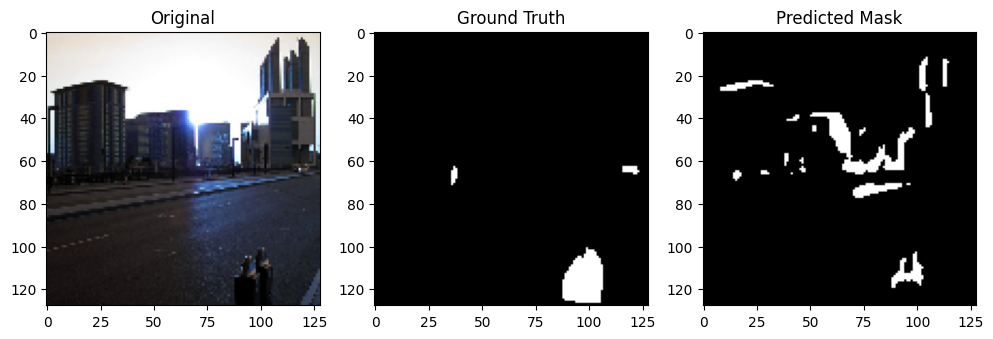

In [ ]:
# Show prediction
def show_prediction(model, X, y_true, idx):
    pred_mask = model.predict(np.expand_dims(X[idx], axis=0))[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(X[idx])

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y_true[idx].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

# Display sample prediction
show_prediction(model, X_val, y_val, idx=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


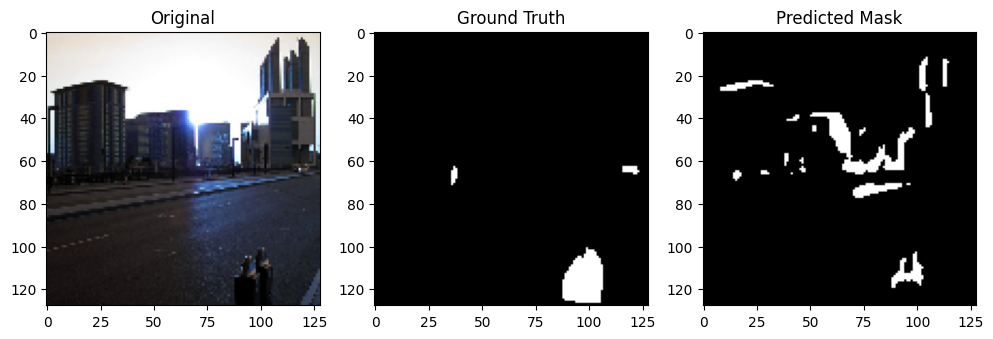

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


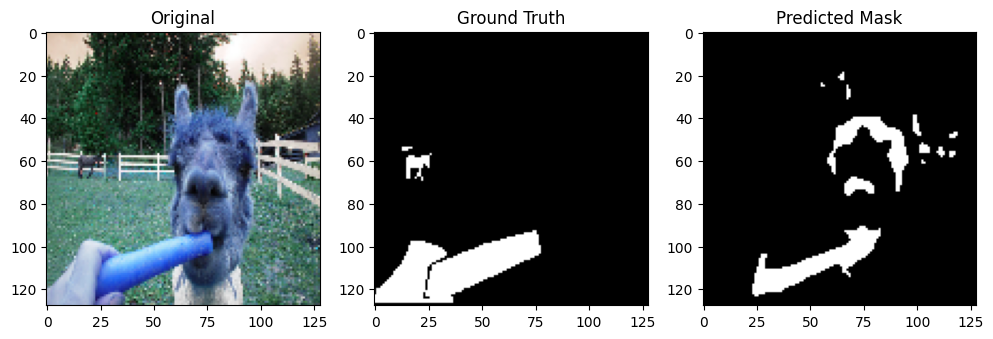

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


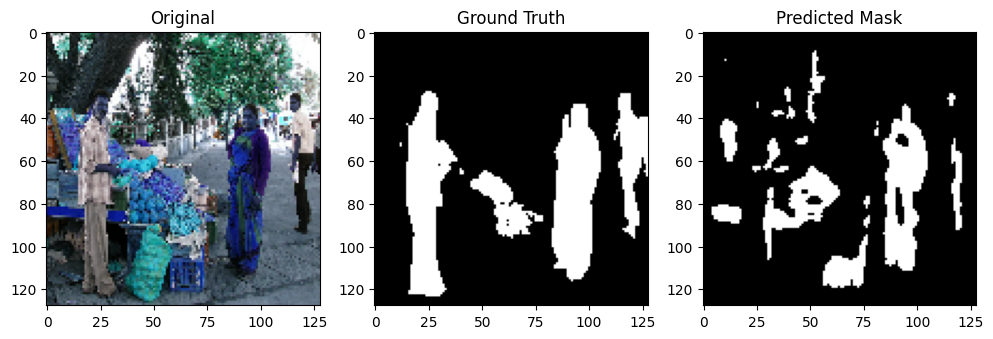

In [ ]:
# Show prediction for 3 sample images
for idx in [1, 5, 10]:  # You can change these indices based on your dataset size
    show_prediction(model, X_val, y_val, idx)
